# Radiative Transfer for Roodeplaat on 2016-06-05

This notebook is essentially the libRadtran equivalent of the Matlab scripts that perform the radiative transfer calculations for the Sentinel 3 overpass on Sunday 2016-06-05.

In [1]:
import morticia.rad.librad as librad
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipyparallel import Client  # This is the client class for contacting the hub/controller
import datetime
import pytz
# use latex for font rendering
mpl.rcParams['text.usetex'] = True  # Use TeX to format labels (takes a bit longer)
%matplotlib inline

In [2]:
# Create a blank case
#S3 = librad.Case(casename='S3toTOAon20160605')
S3 = librad.Case(casename='AerAng600to900nm')

In [3]:
# Set revision
revision = '00A'

# Choose basic atmospheric profile
atmos_profile = '../data/atmmod/afglmw.dat'
S3.set_option('atmosphere_file', atmos_profile)  # mid-latitude winter standard atmosphere

# Modify the ozone and water vapour column amounts
#S3.set_option('mol_modify H2O', 10.5, 'MM')  # Total water vapour column in mm
#S3.set_option('mol_modify O3', 266.1, 'DU')  # Total ozone column in Dobson units

# Change to the Thuillier spectrum and set wavelength range appropriately
solar_toa_file = '../data/solar_flux/Solar_irradiance_Thuillier_2002.txt'
# solar_toa_file = '../data/solar_flux/atlas_plus_modtran'
solar_toa_file = '../data/solar_flux/kurudz_1.0nm.dat'

# Choose start and stop wavelengths and minimum edge margin in nm
wv_minimum_range = [[385.0, -2.0], [955.0, 2.0]]
# Find the nearest wavelengths in the solar file
#wv_range = librad.lookup_nearest_in_file('data/Solar_irradiance_Thuillier_2002.txt', wv_minimum_range)  # lookup in local copy
S3.set_option('source solar', solar_toa_file)
#S3.set_option('wavelength', wv_range[0], wv_range[1])  # Wavelength must exist in the source solar file
S3.set_option('wavelength', 600.0, 900.0)

# Set up dates and times
overpass_datetime = datetime.datetime(2016, 6, 5, 7, 42, 31, tzinfo=pytz.utc)  # Overpass date and time down to second
overpass_datestr = overpass_datetime.strftime('%Y%m%d')
# Get the day of year
day_of_year = int(overpass_datetime.strftime('%j'))
# S3.set_option('day_of_year', day_of_year)

results_folder = 'ResultsS3on' + overpass_datestr + 'Rev' + revision

# Choose band model
#S3.set_option('mol_abs_param reptran coarse')

# Choose solver
S3.set_option('rte_solver disort')

# Set ground altitude
S3.set_option('altitude', 1.225)  # ground altitude in km above sea level

# Set ground albedo
S3.set_option('albedo 0.5')

# Set up aerosol model
S3.set_option('aerosol_default')
# S3.set_option('aerosol_vulcan', 1)               # Aerosol type above 2km
#S3.set_option('aerosol_season', 1)               # Summer season
#S3.set_option('aerosol_visibility', 20.0)        # Visibility
#S3.set_option('aerosol_haze', 5)                 # Shettle/Fenn urban aerosol
aot_wv = np.array([440, 500, 675, 870], dtype=np.float)  # MicroTOPS measurement wavelengths
aot = np.array([0.703, 0.615, 0.362, 0.206])  # MicroTOPS measurements
# Fit Angstrom law to data
alpha, beta = librad.angstrom_law_fit(aot_wv, aot)
# Fit King Byrne formula
alpha_0, alpha_1, alpha_2 = librad.king_byrne_formula_fit(aot_wv, aot)
S3.set_option('aerosol_angstrom', alpha, beta)
#S3.set_option('aerosol_king_byrne', alpha_0, alpha_1, alpha_2)

#S3.set_option('output_quantity transmittance')

# Set up viewing and solar geometry. Note that these angles are taken from the S3 product and special
# care has to be taken when putting geometry information into libRadtran
OAA = 104.01066  # deg. Observation azimuth angle (presumably relative to north through east, satellite from dam)
OZA = 14.151356  # deg. Observation zenith angle (satellite zenith angle as seen from the dam)
SAA = 38.719933  # deg. Solar azimuth angle (presumably relative to north through east)
SZA = 59.316036  # deg. Solar zenith angle

S3.set_option('sza', SZA)  # deg. This one is straightforward
# Now when entering solar and observation zenith angles, it is necessary to provide the azimuth of light propagation
# rather than the azimuth of the view direction, which is 180 deg different
#S3.set_option('phi0', 180.0 - SAA)  # solar radiation propagation azimuth from north through east
#S3.set_option('phi', OAA)  # This is the azimuth of the satellite as seen from the target - also azimuth of light propgation
#S3.set_option('umu', np.cos(np.deg2rad(OZA))) # For downward-looking (upward propagating), check that umu is positive

S3.set_option('verbose')

#S3.set_option('zout boa')
S3.purge = False  # Prevent purging of output files


In [4]:
print S3

atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 600.0 900.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.68488875619 0.181751188084
sza 59.316036
verbose 


In [5]:
# To copy a case it is necessary to use the deepcopy operation
# If you use S3b = S3, both variables point to the same copy
import copy
S3b = copy.deepcopy(S3)
#S3b.name = 'S3toTOAon20160605b'
S3b.name = 'AerAng650to800nm'
S3b.set_option('wavelength', 650.0, 800.0)
# S3b.set_option('aerosol_visibility', 5.0)

In [6]:
S3b

atmosphere_file ../data/atmmod/afglmw.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat
wavelength 650.0 800.0
rte_solver disort
altitude 1.225
albedo 0.5
aerosol_default 
aerosol_angstrom 1.68488875619 0.181751188084
sza 59.316036
verbose 

In [7]:

# Create the ipyparallel client and contact the hub/controller using the profile called icebow and SSH
# to the machine at the IP address 146.64.246.95
# This will cause ipyparall to look in ~/.ipython/profile_icebow/security for a file named ipcontroller_client.json.
# This file is generated by the hub/controller process when started using the ipcluster or ipcontroller command and
# it may need to be copied from the host running the hub/controller to the machine running the client.
#

paraclient = Client(profile='f2', sshserver='dgriffith@f2.csir.co.za', password='mandamoggie')

In [8]:
# Obtain a "load-balanced" view of the engine cluster
paraview = paraclient.load_balanced_view()
# Set the view to blocking mode, which means that we wait for all engines to complete the task before
# control is returned to the client
paraview.block = True
# We will use dill instead of the standard pickle so that we can send instance methods to engines
paraclient[:].use_dill()

<AsyncResult: use_dill>

In [9]:
# Now try to run the batch on the cluster
S3List = paraview.map(librad.Case.run, [S3, S3b])

In [10]:
S3 = S3List[0]
S3b = S3List[1]

In [11]:
# Check for any errors by printing the return code and anything written to stderr
print 'Return Codes : ', S3.run_return_code, ' and ', S3b.run_return_code
S3.stderr

Return Codes :  0  and  0


[' ... using CH4 volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using N2O volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using CO volume mixing ratio profile from US standard atmosphere.\n',
 ' ... using N2 volume mixing ratio profile from US standard atmosphere.\n',
 ' ... calling uvspec_check(), checking model input data\n',
 ' ... calling setup_wlgrid(), generating transmittance wavelength grid\n',
 '     reading bands from ../data/correlated_k/reptran/reptran_solar_coarse.cdf.\n',
 '       371 wavelengths set by set_transmittance_wl_grid_reptran().\n',
 ' ... calling setup_rte_wlgrid(), generating radiative transfer wavelength grid\n',
 '       542 wavelengths set by set_rte_wl_grid_reptran().\n',
 '      transmittance wavelength | radiative transfer wavelength | weight\n',
 '                 599.970093 nm |                 599.831543 nm | 1.000000  \n',
 '                 600.510559 nm |                 600.453247 nm | 1.000000  \n',
 '   

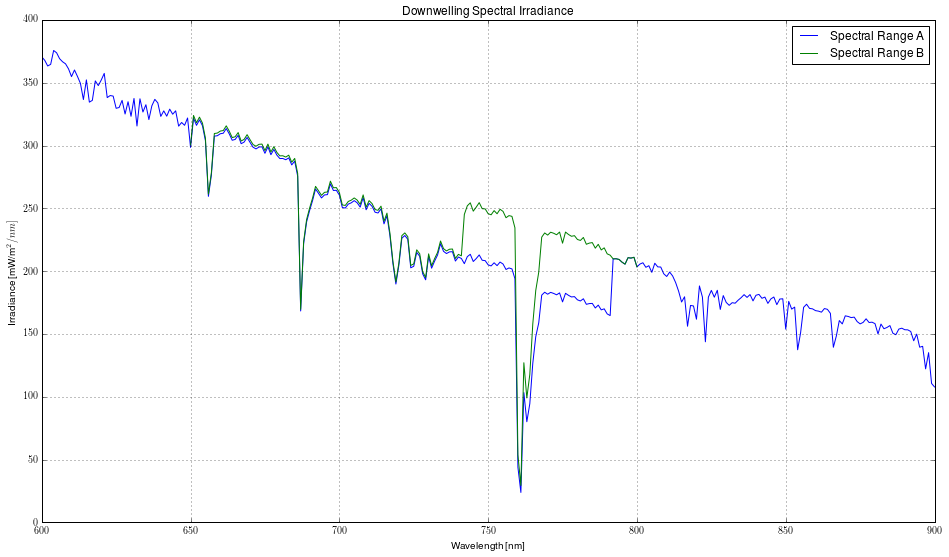

In [13]:
plt.figure(figsize=(16,9))
plt.plot(S3.wvl, S3.edn, S3b.wvl, S3b.edn)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Irradiance [mW/m^2/nm]')
plt.title('Downwelling Spectral Irradiance')
plt.legend(['Spectral Range A', 'Spectral Range B'])
plt.grid()
plt.savefig('ednAerAng.pdf')

In [7]:
# Check the quality of the Angstrom Law and King-Byrne formula fits
the_wv = np.arange(350.0, 950.0, 10.0)  # Pick a wavelength range
the_aot = librad.king_byrne_formula(the_wv, alpha_0, alpha_1, alpha_2)  # Calculate King-Byrne 
aot_ang = librad.angstrom_law(the_wv, alpha, beta)  # Calculate Angstrom Law

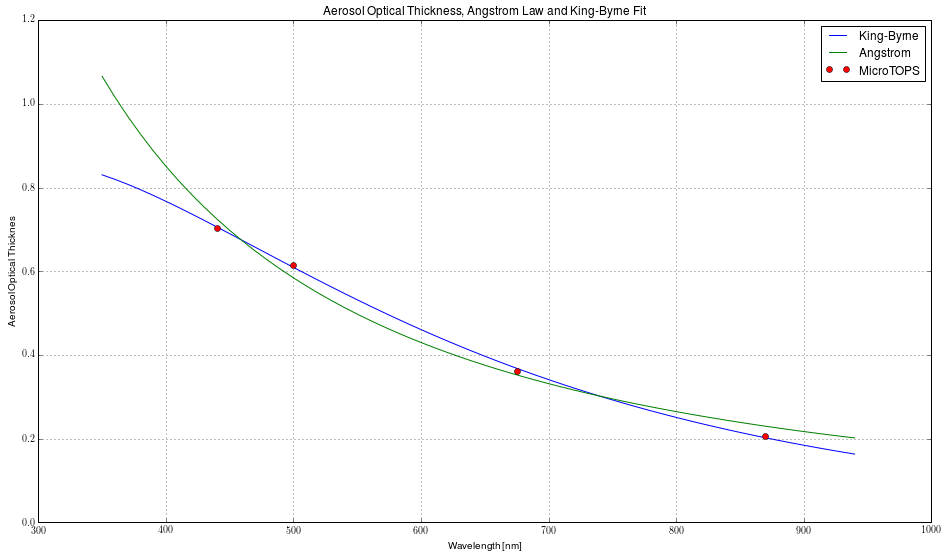

In [48]:
# Plot Angstrom Law and King-Byrne fitted curves with MicroTOPS measurements
plt.figure(figsize=(16,9))
plt.plot(the_wv, the_aot, the_wv, aot_ang, aot_wv, aot, 'o')
plt.xlabel('Wavelength [nm]')
plt.ylabel('Aerosol Optical Thicknes')
plt.title('Aerosol Optical Thickness, Angstrom Law and King-Byrne Fit')
plt.legend(['King-Byrne', 'Angstrom', 'MicroTOPS'])
plt.grid()


In [1]:
19.5 * 6.7

130.65